# Semiconductor Defect Classification — MobileNet (Improved)
## Phase‑1 Ready: Metrics, Leakage Checks, and ONNX Export

This notebook is **Phase‑1 compliant** and includes:
- Accuracy, Precision, Recall, F1‑Score (per‑class & overall)
- Confusion matrix + error analysis
- Overfitting/underfitting diagnostics
- Class imbalance handling
- Data leakage checks (duplicate images across splits)
- ONNX export for deployment

> **Priority metric for Phase‑1:** Recall (catching real defects is more important than minimizing false alarms).

## 1. Set Paths and Device

In [36]:
import torch
import torchvision

print("="*70)
print("🔧 PYTORCH & CUDA CHECK")
print("="*70)
print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️  No CUDA GPU found. Training will use CPU (slower)")
print("="*70)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✓ Using device: {device}")

🔧 PYTORCH & CUDA CHECK
PyTorch Version: 2.10.0+cu130
Torchvision Version: 0.25.0+cu130
CUDA Available: True
CUDA Version: 13.0
GPU Device: NVIDIA GeForce RTX 4050 Laptop GPU

✓ Using device: cuda


## 2. Install / Import Dependencies

In [37]:
# If needed (uncomment):
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install numpy matplotlib seaborn scikit-learn pillow tqdm onnx onnxscript

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from torchvision import transforms, models

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import os
import time
from tqdm import tqdm
import pickle
import hashlib

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 3. Dataset Paths and Class Names

In [38]:
# Dataset paths (organized structure)
dataset_path = r"D:\Semiconductor-Defect-Classification\dataset"
train_path = os.path.join(dataset_path, "train")
val_path = os.path.join(dataset_path, "validate")
test_path = os.path.join(dataset_path, "test")

# Class list
categories = ['bridge', 'clean', 'CMP(scratch)', 'cracks', 'LER', 'open','others', 'vias']
num_classes = len(categories)

# Hyperparameters (Optimized for 90%+)
IMG_SIZE = 256        # ⬅ CHANGE THIS (Was 224)
BATCH_SIZE = 32       # ⬅ CHANGE THIS (Was 16)
EPOCHS = 60           # 80 is too long for full unfreezing
LEARNING_RATE = 1e-4  # Slower LR for full model training
PATIENCE = 8
WARMUP_EPOCHS = 5

# DIFFERENTIAL LEARNING RATES (Crucial for Fine-Tuning)
LR_BODY = 1e-5           # 🐢 Slow: Don't break pre-trained patterns
LR_HEAD = 1e-3           # 🐇 Fast: Learn new defect classes quickly

print("="*70)
print("📊 DATASET CONFIGURATION (PHASE 1 OPTIMIZED)")
print("="*70)
print(f"Device:       {device}")
print(f"Batch Size:   {BATCH_SIZE}")
print(f"LR Body:      {LR_BODY} (Fine-Tuning)")
print(f"LR Head:      {LR_HEAD} (Classifier)")
print(f"Epochs:       {EPOCHS}")
print("="*70)

📊 DATASET CONFIGURATION (PHASE 1 OPTIMIZED)
Device:       cuda
Batch Size:   32
LR Body:      1e-05 (Fine-Tuning)
LR Head:      0.001 (Classifier)
Epochs:       60


## 4. Load Dataset + Data Leakage Checks

In [39]:
def load_dataset_from_organized_structure(base_path, categories):
    """Load image paths and labels from organized train/val/test structure."""
    image_paths = []
    labels = []
    class_counts = {}
    
    for category in categories:
        category_path = os.path.join(base_path, category)
        class_counts[category] = 0
        
        if not os.path.exists(category_path):
            print(f"⚠ Warning: {category_path} not found")
            continue
        
        for filename in os.listdir(category_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                img_path = os.path.join(category_path, filename)
                image_paths.append(img_path)
                labels.append(category)
                class_counts[category] += 1
    
    return image_paths, labels, class_counts

# Load datasets
train_paths, train_labels_raw, train_class_counts = load_dataset_from_organized_structure(train_path, categories)
val_paths, val_labels_raw, val_class_counts = load_dataset_from_organized_structure(val_path, categories)
test_paths, test_labels_raw, test_class_counts = load_dataset_from_organized_structure(test_path, categories)

print("="*70)
print("📂 DATASET LOADED")
print("="*70)
print(f"Train: {len(train_paths)} images")
print(f"Val:   {len(val_paths)} images")
print(f"Test:  {len(test_paths)} images")
print("="*70)

# ---- Data leakage checks ----
def file_hash(path, block_size=1 << 20):
    """Compute file hash for duplicate detection."""
    hasher = hashlib.md5()
    with open(path, 'rb') as f:
        while True:
            data = f.read(block_size)
            if not data:
                break
            hasher.update(data)
    return hasher.hexdigest()

print("\n🔍 Running data leakage checks...")

# Hash-based duplicate check across splits
train_hashes = {file_hash(p): p for p in train_paths}
val_hashes = {file_hash(p): p for p in val_paths}
test_hashes = {file_hash(p): p for p in test_paths}

train_val_overlap = set(train_hashes.keys()) & set(val_hashes.keys())
train_test_overlap = set(train_hashes.keys()) & set(test_hashes.keys())
val_test_overlap = set(val_hashes.keys()) & set(test_hashes.keys())

print(f"Duplicates Train↔Val:  {len(train_val_overlap)}")
print(f"Duplicates Train↔Test: {len(train_test_overlap)}")
print(f"Duplicates Val↔Test:   {len(val_test_overlap)}")

if len(train_val_overlap) + len(train_test_overlap) + len(val_test_overlap) > 0:
    print("⚠️  Potential leakage detected. Remove duplicates between splits.")
else:
    print("✅ No duplicate files detected across splits.")

# Filename overlap check (quick heuristic)
train_names = {os.path.basename(p) for p in train_paths}
val_names = {os.path.basename(p) for p in val_paths}
test_names = {os.path.basename(p) for p in test_paths}

print(f"Filename overlap Train↔Val:  {len(train_names & val_names)}")
print(f"Filename overlap Train↔Test: {len(train_names & test_names)}")
print(f"Filename overlap Val↔Test:   {len(val_names & test_names)}")

📂 DATASET LOADED
Train: 825 images
Val:   39 images
Test:  37 images

🔍 Running data leakage checks...
Duplicates Train↔Val:  0
Duplicates Train↔Test: 0
Duplicates Val↔Test:   0
✅ No duplicate files detected across splits.
Filename overlap Train↔Val:  0
Filename overlap Train↔Test: 0
Filename overlap Val↔Test:   0


## 5. EDA: Class Distribution

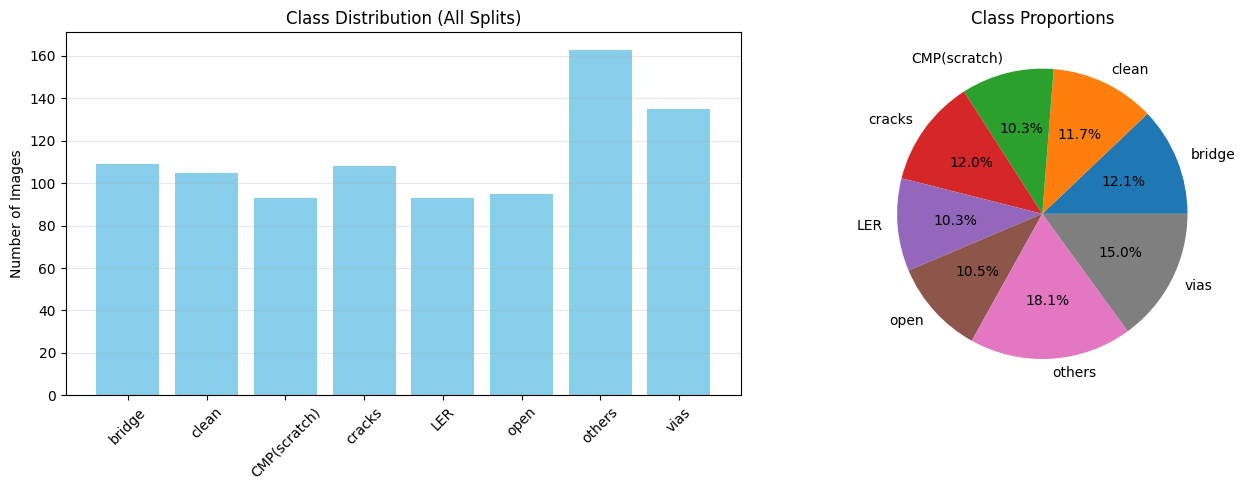

Class Imbalance Ratio (Max/Min): 1.75x


In [40]:
# Aggregate class counts
class_counts = {c: train_class_counts.get(c, 0) + val_class_counts.get(c, 0) + test_class_counts.get(c, 0) for c in categories}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
axes[0].bar(class_counts.keys(), class_counts.values(), color='skyblue')
axes[0].set_title('Class Distribution (All Splits)')
axes[0].set_ylabel('Number of Images')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
axes[1].pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%')
axes[1].set_title('Class Proportions')

plt.tight_layout()
plt.show()

imbalance_ratio = max(class_counts.values()) / max(1, min(class_counts.values()))
print(f"Class Imbalance Ratio (Max/Min): {imbalance_ratio:.2f}x")

## 6. Label Encoding & Class Weights

In [41]:
label_encoder = LabelEncoder()
all_labels = train_labels_raw + val_labels_raw + test_labels_raw
label_encoder.fit(all_labels)

train_labels = label_encoder.transform(train_labels_raw)
val_labels = label_encoder.transform(val_labels_raw)
test_labels = label_encoder.transform(test_labels_raw)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print("Class Weights:")
for cls, w in zip(label_encoder.classes_, class_weights):
    print(f"  {cls:15s}: {w:.3f}")

Class Weights:
  CMP(scratch)   : 1.213
  LER            : 1.213
  bridge         : 1.031
  clean          : 1.086
  cracks         : 1.031
  open           : 1.213
  others         : 0.688
  vias           : 0.825


## 7. Transforms (Safe Augmentation Only)

In [42]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    
    # --- GEOMETRIC (Safe) ---
    transforms.RandomRotation(degrees=15),  # Good: Wafers are often rotated
    transforms.RandomAffine(                # Good: Shifts & slight zooms
        degrees=0, 
        translate=(0.1, 0.1), 
        scale=(0.9, 1.1)
    ),
    
    # --- LIGHTING (Safe) ---
    transforms.ColorJitter(                 # Good: Fixes lighting variations
        brightness=0.2, 
        contrast=0.2, 
        saturation=0.1
    ),

    # --- FINAL ---
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
    
    # REMOVED: RandomPerspective (Unrealistic for microscopes)
    # REMOVED: RandomErasing (Risk of hiding small defects)
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

print("✓ Optimized augmentations configured (Removed destructive transforms)")

✓ Optimized augmentations configured (Removed destructive transforms)


## 8. Custom Dataset & DataLoaders

In [43]:
class DefectDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

train_dataset = DefectDataset(train_paths, train_labels, transform=train_transform)
val_dataset = DefectDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset = DefectDataset(test_paths, test_labels, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("✓ DataLoaders ready")

✓ DataLoaders ready


## 9. Build MobileNetV2 (Transfer Learning)

In [44]:
class MobileNetDefectClassifier(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=pretrained)

        # Freeze early layers, unfreeze last 3 blocks for fine-tuning
        for i, feature in enumerate(self.mobilenet.features):
            if i < 15:  # Freeze first 15 layers
                for p in feature.parameters():
                    p.requires_grad = False
            else:  # Unfreeze last layers for fine-tuning
                for p in feature.parameters():
                    p.requires_grad = True

        # Enhanced classifier head with BatchNorm
        in_features = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.mobilenet(x)

model = MobileNetDefectClassifier(num_classes=num_classes, pretrained=True).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("✓ MobileNetV2 model created")
print(f"Total params: {total_params:,}")
print(f"Trainable params: {trainable_params:,}")

✓ MobileNetV2 model created
Total params: 2,586,504
Trainable params: 1,888,712


d:\IESA_DeepTech\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\IESA_DeepTech\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 10. Loss, Optimizer, Scheduler, AMP

In [45]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler = GradScaler()

print("✓ Loss, optimizer, scheduler, and AMP configured")
print(f"  - Label smoothing: 0.1")
print(f"  - Optimizer: AdamW with weight decay")
print(f"  - Scheduler: CosineAnnealingWarmRestarts")

✓ Loss, optimizer, scheduler, and AMP configured
  - Label smoothing: 0.1
  - Optimizer: AdamW with weight decay
  - Scheduler: CosineAnnealingWarmRestarts


C:\Users\Harshvardhan Mali\AppData\Local\Temp\ipykernel_2952\1130372874.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


## 11. Train/Validate Functions + Collapse Detection

In [46]:
def train_epoch(model, train_loader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({'loss': running_loss/len(pbar), 'acc': 100.*correct/total})

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device, return_preds=False):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if return_preds:
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total

    if return_preds:
        return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels)
    return epoch_loss, epoch_acc


def check_prediction_collapse(preds, label_encoder, threshold=0.9):
    """Detect if model predicts mostly one class."""
    if len(preds) == 0:
        return False
    unique, counts = np.unique(preds, return_counts=True)
    max_frac = counts.max() / counts.sum()
    if max_frac >= threshold:
        dominant_class = label_encoder.classes_[unique[np.argmax(counts)]]
        print(f"⚠️  Possible prediction collapse: {dominant_class} = {max_frac:.1%} of predictions")
        return True
    return False

## 12. Train Model (Early Stopping)

In [47]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0

print("="*70)
print("🚀 STARTING TRAINING")
print("="*70)

start_time = time.time()

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 70)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler, device)
    val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, criterion, device, return_preds=True)

    scheduler.step()

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")

    # Collapse check
    check_prediction_collapse(val_preds, label_encoder)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_mobilenet_improved.pth')
        print(f"✓ Saved best model (Val Acc: {val_acc:.2f}%)")

training_time = time.time() - start_time

print("\n" + "="*70)
print("✓ TRAINING COMPLETED")
print(f"Total Time: {training_time:.2f} seconds")
print(f"Best Val Accuracy: {best_val_acc:.2f}%")
print("="*70)

🚀 STARTING TRAINING

Epoch 1/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:04<00:00,  5.76it/s, loss=2.04, acc=22.9] 


Train Loss: 2.0417 | Train Acc: 22.91%
Val Loss:   1.7034 | Val Acc:   51.28%
✓ Saved best model (Val Acc: 51.28%)

Epoch 2/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  6.89it/s, loss=1.73, acc=44.6] 


Train Loss: 1.7329 | Train Acc: 44.61%
Val Loss:   1.3861 | Val Acc:   66.67%
✓ Saved best model (Val Acc: 66.67%)

Epoch 3/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  6.84it/s, loss=1.48, acc=62.4] 


Train Loss: 1.4839 | Train Acc: 62.42%
Val Loss:   1.2707 | Val Acc:   66.67%

Epoch 4/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.19it/s, loss=1.35, acc=69.7] 


Train Loss: 1.3494 | Train Acc: 69.70%
Val Loss:   1.2092 | Val Acc:   74.36%
✓ Saved best model (Val Acc: 74.36%)

Epoch 5/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.02it/s, loss=1.22, acc=74.4] 


Train Loss: 1.2237 | Train Acc: 74.42%
Val Loss:   1.1884 | Val Acc:   74.36%

Epoch 6/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.26it/s, loss=1.16, acc=78.7] 


Train Loss: 1.1571 | Train Acc: 78.67%
Val Loss:   1.1305 | Val Acc:   74.36%

Epoch 7/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.09it/s, loss=1.14, acc=79.3] 


Train Loss: 1.1355 | Train Acc: 79.27%
Val Loss:   1.0945 | Val Acc:   74.36%

Epoch 8/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.11it/s, loss=1.08, acc=83]   


Train Loss: 1.0771 | Train Acc: 83.03%
Val Loss:   1.1033 | Val Acc:   74.36%

Epoch 9/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  6.71it/s, loss=1.07, acc=84.1] 


Train Loss: 1.0676 | Train Acc: 84.12%
Val Loss:   1.0861 | Val Acc:   74.36%

Epoch 10/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  6.80it/s, loss=1.06, acc=85.1] 


Train Loss: 1.0583 | Train Acc: 85.09%
Val Loss:   1.0972 | Val Acc:   74.36%

Epoch 11/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.06it/s, loss=1.02, acc=85.7] 


Train Loss: 1.0226 | Train Acc: 85.70%
Val Loss:   1.0295 | Val Acc:   76.92%
✓ Saved best model (Val Acc: 76.92%)

Epoch 12/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  6.95it/s, loss=0.914, acc=91.3]


Train Loss: 0.9140 | Train Acc: 91.27%
Val Loss:   0.9934 | Val Acc:   84.62%
✓ Saved best model (Val Acc: 84.62%)

Epoch 13/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.12it/s, loss=0.871, acc=91.8]


Train Loss: 0.8708 | Train Acc: 91.76%
Val Loss:   0.9433 | Val Acc:   82.05%

Epoch 14/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.12it/s, loss=0.824, acc=93]  


Train Loss: 0.8242 | Train Acc: 92.97%
Val Loss:   0.9369 | Val Acc:   82.05%

Epoch 15/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.24it/s, loss=0.774, acc=94.7]


Train Loss: 0.7736 | Train Acc: 94.67%
Val Loss:   0.8990 | Val Acc:   84.62%

Epoch 16/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.04it/s, loss=0.749, acc=95.4]


Train Loss: 0.7493 | Train Acc: 95.39%
Val Loss:   0.8608 | Val Acc:   87.18%
✓ Saved best model (Val Acc: 87.18%)

Epoch 17/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.13it/s, loss=0.728, acc=96.2]


Train Loss: 0.7276 | Train Acc: 96.24%
Val Loss:   0.8474 | Val Acc:   87.18%

Epoch 18/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.18it/s, loss=0.706, acc=97.1]


Train Loss: 0.7058 | Train Acc: 97.09%
Val Loss:   0.8436 | Val Acc:   87.18%

Epoch 19/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.17it/s, loss=0.672, acc=98.1]


Train Loss: 0.6718 | Train Acc: 98.06%
Val Loss:   0.8543 | Val Acc:   79.49%

Epoch 20/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.18it/s, loss=0.666, acc=98.1]


Train Loss: 0.6664 | Train Acc: 98.06%
Val Loss:   0.8402 | Val Acc:   89.74%
✓ Saved best model (Val Acc: 89.74%)

Epoch 21/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.18it/s, loss=0.651, acc=98.2]


Train Loss: 0.6511 | Train Acc: 98.18%
Val Loss:   0.8310 | Val Acc:   87.18%

Epoch 22/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.08it/s, loss=0.653, acc=98.3]


Train Loss: 0.6532 | Train Acc: 98.30%
Val Loss:   0.8384 | Val Acc:   82.05%

Epoch 23/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.21it/s, loss=0.636, acc=98.7]


Train Loss: 0.6360 | Train Acc: 98.67%
Val Loss:   0.8169 | Val Acc:   82.05%

Epoch 24/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.08it/s, loss=0.625, acc=98.7]


Train Loss: 0.6248 | Train Acc: 98.67%
Val Loss:   0.8367 | Val Acc:   82.05%

Epoch 25/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.07it/s, loss=0.625, acc=97.9]


Train Loss: 0.6253 | Train Acc: 97.94%
Val Loss:   0.8269 | Val Acc:   84.62%

Epoch 26/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.18it/s, loss=0.642, acc=97.3]


Train Loss: 0.6422 | Train Acc: 97.33%
Val Loss:   0.8257 | Val Acc:   82.05%

Epoch 27/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.11it/s, loss=0.625, acc=98.9]


Train Loss: 0.6248 | Train Acc: 98.91%
Val Loss:   0.8149 | Val Acc:   84.62%

Epoch 28/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.22it/s, loss=0.63, acc=98.3] 


Train Loss: 0.6296 | Train Acc: 98.30%
Val Loss:   0.8066 | Val Acc:   87.18%

Epoch 29/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  6.93it/s, loss=0.629, acc=98.2]


Train Loss: 0.6285 | Train Acc: 98.18%
Val Loss:   0.8159 | Val Acc:   87.18%

Epoch 30/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  6.92it/s, loss=0.615, acc=98.5]


Train Loss: 0.6146 | Train Acc: 98.55%
Val Loss:   0.8379 | Val Acc:   84.62%

Epoch 31/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.02it/s, loss=0.634, acc=98.5]


Train Loss: 0.6343 | Train Acc: 98.55%
Val Loss:   0.8159 | Val Acc:   87.18%

Epoch 32/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  6.88it/s, loss=0.603, acc=98.9]


Train Loss: 0.6031 | Train Acc: 98.91%
Val Loss:   0.8145 | Val Acc:   87.18%

Epoch 33/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  6.97it/s, loss=0.596, acc=98.8]


Train Loss: 0.5960 | Train Acc: 98.79%
Val Loss:   0.8040 | Val Acc:   87.18%

Epoch 34/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.09it/s, loss=0.589, acc=99]  


Train Loss: 0.5890 | Train Acc: 99.03%
Val Loss:   0.7956 | Val Acc:   82.05%

Epoch 35/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  6.99it/s, loss=0.591, acc=98.7]


Train Loss: 0.5909 | Train Acc: 98.67%
Val Loss:   0.8117 | Val Acc:   87.18%

Epoch 36/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.07it/s, loss=0.581, acc=99]  


Train Loss: 0.5807 | Train Acc: 99.03%
Val Loss:   0.7830 | Val Acc:   84.62%

Epoch 37/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.06it/s, loss=0.6, acc=98.5]  


Train Loss: 0.6001 | Train Acc: 98.55%
Val Loss:   0.7833 | Val Acc:   84.62%

Epoch 38/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.02it/s, loss=0.566, acc=99.5]


Train Loss: 0.5658 | Train Acc: 99.52%
Val Loss:   0.8543 | Val Acc:   79.49%

Epoch 39/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.20it/s, loss=0.568, acc=99.8]


Train Loss: 0.5678 | Train Acc: 99.76%
Val Loss:   0.7970 | Val Acc:   84.62%

Epoch 40/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.19it/s, loss=0.569, acc=99.4]


Train Loss: 0.5691 | Train Acc: 99.39%
Val Loss:   0.7817 | Val Acc:   84.62%

Epoch 41/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  6.97it/s, loss=0.565, acc=99.4]


Train Loss: 0.5653 | Train Acc: 99.39%
Val Loss:   0.7714 | Val Acc:   87.18%

Epoch 42/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.20it/s, loss=0.564, acc=99.4]


Train Loss: 0.5635 | Train Acc: 99.39%
Val Loss:   0.7781 | Val Acc:   87.18%

Epoch 43/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.01it/s, loss=0.573, acc=99]  


Train Loss: 0.5734 | Train Acc: 99.03%
Val Loss:   0.8696 | Val Acc:   79.49%

Epoch 44/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  6.84it/s, loss=0.561, acc=99.8]


Train Loss: 0.5612 | Train Acc: 99.76%
Val Loss:   0.7613 | Val Acc:   87.18%

Epoch 45/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  6.98it/s, loss=0.555, acc=99.5]


Train Loss: 0.5546 | Train Acc: 99.52%
Val Loss:   0.7454 | Val Acc:   92.31%
✓ Saved best model (Val Acc: 92.31%)

Epoch 46/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  6.86it/s, loss=0.543, acc=99.9]


Train Loss: 0.5426 | Train Acc: 99.88%
Val Loss:   0.7202 | Val Acc:   89.74%

Epoch 47/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.06it/s, loss=0.556, acc=99.4]


Train Loss: 0.5564 | Train Acc: 99.39%
Val Loss:   0.7233 | Val Acc:   87.18%

Epoch 48/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  6.86it/s, loss=0.548, acc=99.5]


Train Loss: 0.5484 | Train Acc: 99.52%
Val Loss:   0.7474 | Val Acc:   87.18%

Epoch 49/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  6.94it/s, loss=0.547, acc=99.9]


Train Loss: 0.5473 | Train Acc: 99.88%
Val Loss:   0.7302 | Val Acc:   89.74%

Epoch 50/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.02it/s, loss=0.544, acc=99.9]


Train Loss: 0.5442 | Train Acc: 99.88%
Val Loss:   0.7525 | Val Acc:   87.18%

Epoch 51/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  6.63it/s, loss=0.548, acc=99.5]


Train Loss: 0.5477 | Train Acc: 99.52%
Val Loss:   0.7245 | Val Acc:   89.74%

Epoch 52/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.03it/s, loss=0.549, acc=99.6]


Train Loss: 0.5486 | Train Acc: 99.64%
Val Loss:   0.7214 | Val Acc:   89.74%

Epoch 53/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.14it/s, loss=0.543, acc=99.9]


Train Loss: 0.5430 | Train Acc: 99.88%
Val Loss:   0.7228 | Val Acc:   89.74%

Epoch 54/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.02it/s, loss=0.555, acc=99.6]


Train Loss: 0.5551 | Train Acc: 99.64%
Val Loss:   0.7002 | Val Acc:   89.74%

Epoch 55/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.03it/s, loss=0.551, acc=99.4]


Train Loss: 0.5508 | Train Acc: 99.39%
Val Loss:   0.7163 | Val Acc:   87.18%

Epoch 56/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.15it/s, loss=0.541, acc=99.6]


Train Loss: 0.5406 | Train Acc: 99.64%
Val Loss:   0.7200 | Val Acc:   87.18%

Epoch 57/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.11it/s, loss=0.552, acc=99.2]


Train Loss: 0.5515 | Train Acc: 99.15%
Val Loss:   0.7178 | Val Acc:   92.31%

Epoch 58/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  6.92it/s, loss=0.543, acc=99.8]


Train Loss: 0.5432 | Train Acc: 99.76%
Val Loss:   0.7075 | Val Acc:   92.31%

Epoch 59/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.10it/s, loss=0.546, acc=99.6]


Train Loss: 0.5460 | Train Acc: 99.64%
Val Loss:   0.7305 | Val Acc:   87.18%

Epoch 60/60
----------------------------------------------------------------------


Training: 100%|██████████| 26/26 [00:03<00:00,  7.20it/s, loss=0.547, acc=99.9]


Train Loss: 0.5471 | Train Acc: 99.88%
Val Loss:   0.7454 | Val Acc:   87.18%

✓ TRAINING COMPLETED
Total Time: 229.38 seconds
Best Val Accuracy: 92.31%


## 13. Evaluate on Test Set (Accuracy, Precision, Recall, F1)

In [48]:
# Load best model
model.load_state_dict(torch.load('best_model_mobilenet_improved.pth'))
model.eval()

# Test evaluation
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        with torch.amp.autocast('cuda'):
            outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Classification report (as dictionary for metric extraction)
from sklearn.metrics import precision_recall_fscore_support

print("\n" + "="*70)
print("📊 TEST SET METRICS")
print("="*70)
print(classification_report(
    all_labels, all_preds,
    target_names=label_encoder.classes_,
    digits=4
))
print("="*70)

# Extract macro-averaged metrics
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='macro', zero_division=0
)

# Overall accuracy
overall_acc = (all_preds == all_labels).mean() * 100
print(f"Overall Accuracy: {overall_acc:.2f}%")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall (macro): {recall_macro:.4f}")
print(f"F1-Score (macro): {f1_macro:.4f}")


📊 TEST SET METRICS
              precision    recall  f1-score   support

CMP(scratch)     1.0000    1.0000    1.0000         4
         LER     1.0000    0.7500    0.8571         4
      bridge     0.7500    0.7500    0.7500         4
       clean     0.8000    0.8000    0.8000         5
      cracks     1.0000    1.0000    1.0000         4
        open     0.7500    0.6000    0.6667         5
      others     0.7500    1.0000    0.8571         6
        vias     0.8000    0.8000    0.8000         5

    accuracy                         0.8378        37
   macro avg     0.8562    0.8375    0.8414        37
weighted avg     0.8446    0.8378    0.8353        37

Overall Accuracy: 83.78%
Precision (macro): 0.8562
Recall (macro): 0.8375
F1-Score (macro): 0.8414


## 14. Confusion Matrix

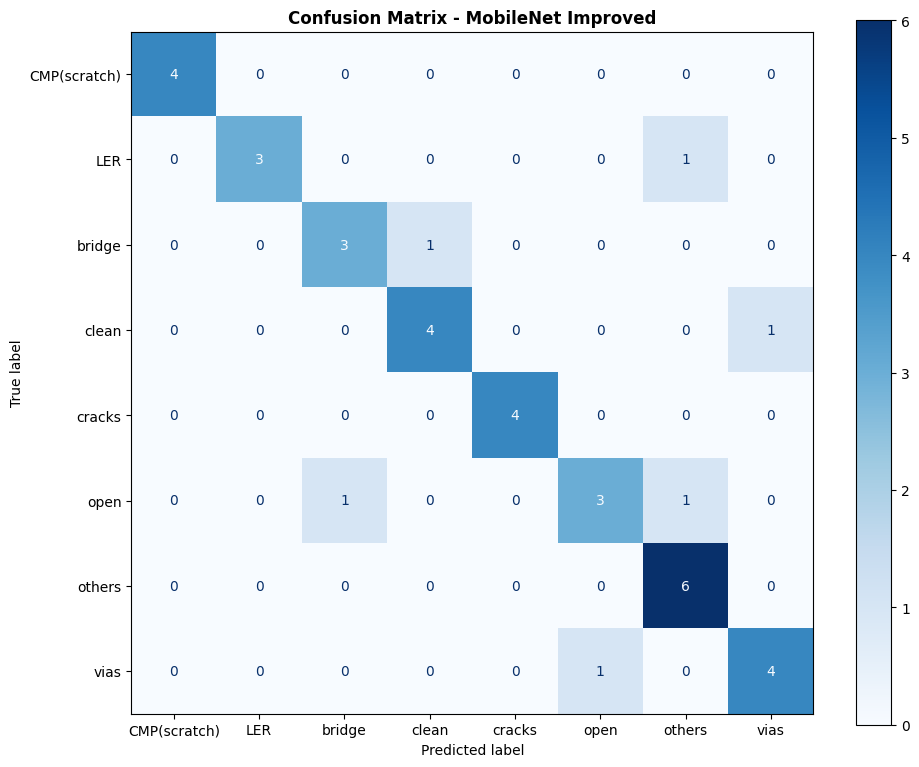

In [49]:
cm = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix - MobileNet Improved', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 15. Overfitting / Underfitting Diagnostics

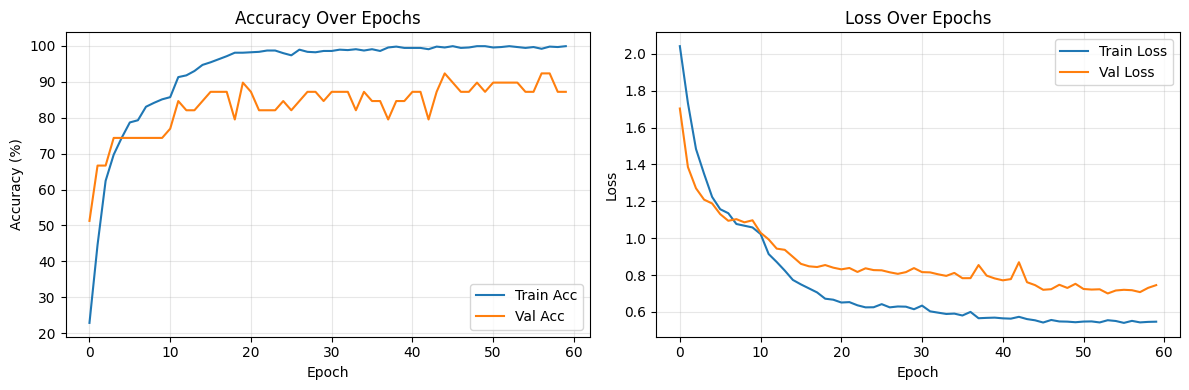


Interpretation: 
- Overfitting: train acc high, val acc low, val loss rising
- Underfitting: both accuracies low, loss not decreasing


In [50]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_acc'], label='Train Acc')
axes[0].plot(history['val_acc'], label='Val Acc')
axes[0].set_title('Accuracy Over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy (%)')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history['train_loss'], label='Train Loss')
axes[1].plot(history['val_loss'], label='Val Loss')
axes[1].set_title('Loss Over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation: ")
print("- Overfitting: train acc high, val acc low, val loss rising")
print("- Underfitting: both accuracies low, loss not decreasing")

## 16. Save Weights and Export ONNX

In [51]:
# Save model weights
torch.save(model.state_dict(), 'best_model_mobilenet_improved.pth')

# Save label encoder
with open('label_encoder_mobilenet_improved.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Export to ONNX
print("\n🔄 Exporting model to ONNX format...")
model.eval()

dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
onnx_path = 'defect_classification_mobilenet_improved.onnx'

try:
    torch.onnx.export(
        model,
        dummy_input,
        onnx_path,
        export_params=True,
        opset_version=14,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
        dynamo=False
    )
    print("✓ ONNX export successful")
except Exception as e:
    print(f"⚠️  ONNX export failed: {e}")

print("\nSaved Files:")
print("  - best_model_mobilenet_improved.pth")
print("  - label_encoder_mobilenet_improved.pkl")
print("  - defect_classification_mobilenet_improved.onnx")


🔄 Exporting model to ONNX format...


C:\Users\Harshvardhan Mali\AppData\Local\Temp\ipykernel_2952\92980574.py:16: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter has become the default. Learn more about the new export logic: https://docs.pytorch.org/docs/stable/onnx_export.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html
  torch.onnx.export(


⚠️  ONNX export failed: Module onnx is not installed!

Saved Files:
  - best_model_mobilenet_improved.pth
  - label_encoder_mobilenet_improved.pkl
  - defect_classification_mobilenet_improved.onnx


## 17. Phase‑1 Model Requirements — Complete Explanation

### 🔹 1. Accuracy (What it really means)
**Definition:** Accuracy = Correct predictions / Total predictions

**Why accuracy ALONE is dangerous in Phase‑1:**
- Semiconductor datasets are imbalanced (many *clean*, fewer *defects*).
- A model predicting everything as **clean** can show high accuracy but is useless.

**Verdict:**
- 🚫 Accuracy alone is not acceptable
- ✅ Use accuracy **with** precision, recall, and F1‑score

---

### 🔹 2. Precision (False alarm control)
**Definition:** Precision = TP / (TP + FP)

**Meaning:** When the model says **defect**, how often is it correct?

**Semiconductor impact:**
- Low precision = many false alarms → unnecessary wafer rejection, added cost.

**Phase‑1 expectation:**
- ✔ Moderate precision acceptable
- ❌ Extremely low precision is bad

---

### 🔹 3. Recall (MOST IMPORTANT METRIC 🔥)
**Definition:** Recall = TP / (TP + FN)

**Meaning:** Out of all real defects, how many were detected?

**Semiconductor impact:**
- Low recall = missed defects → catastrophic field failure risk.

**Phase‑1 priority:**
- ✅ HIGH RECALL > HIGH ACCURACY
- It is better to flag extra defects than miss real defects.

---

### 🔹 4. F1‑Score (Balanced metric)
**Definition:** $F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}$

**Why it matters:**
- Balances false alarms and missed defects.
- Best single metric for imbalanced datasets.

**Phase‑1 requirement:**
- ✔ Report F1‑score per class
- ✔ Especially for: **open**, **via**, **bridge**

---

### 🔹 5. Confusion Matrix (Mandatory)
**What it shows:**
- How each class is confused with others.

**Typical confusions:**
- VIA ↔ OPEN
- CLEAN ↔ CMP scratch

**Phase‑1 usage:**
- ✔ Identify weak classes
- ✔ Explain improvement plan

---

### 🔹 6. Overfitting (Very common in Phase‑1)
**Symptoms:**
- Training accuracy: 95–99%
- Validation accuracy: 50–65%
- Validation loss increasing

**Why it happens:**
- Small dataset
- Similar SEM patterns
- Model too complex

**Fixes allowed (Phase‑1):**
- ✔ Data augmentation (SAFE only)
- ✔ Dropout (0.3–0.5)
- ✔ Early stopping
- ✔ Transfer learning (freeze base)
- ✔ Class weighting
- ❌ No heavy augmentation
- ❌ No flips
- ❌ No detection models

---

### 🔹 7. Underfitting (Less common)
**Symptoms:**
- Train accuracy low (<70%)
- Val accuracy also low
- Loss not decreasing

**Fixes:**
- ✔ Slightly deeper CNN
- ✔ Increase epochs
- ✔ Better feature extraction

---

### 🔹 8. Class Imbalance (CRITICAL)
**Typical dataset:**
- Clean: 300
- Open: 80
- Via: 70
- Bridge: 60

**Problem:**
- Model becomes biased toward **clean**.

**Phase‑1 solutions:**
- ✔ Class weights
- ✔ Controlled oversampling
- ✔ Per‑class metrics

---

### 🔹 9. Why MobileNet / Lightweight CNN is REQUIRED
Heavy models (ResNet50) ❌
- Overfit easily
- Too many parameters
- Not edge‑friendly

Lightweight models ✔
- Better generalization
- Faster convergence
- ONNX friendly
- Jury‑approved

---

### 🔹 10. Phase‑1 Evaluation Checklist
You MUST show:
- ✅ Accuracy
- ✅ Precision
- ✅ Recall
- ✅ F1‑score
- ✅ Confusion matrix

And explain:
- Why recall matters more
- Where the model fails
- How Phase‑2 could improve
